In [1]:
import pickle
import numpy as np
import re
from utils import clean, split_on_caps, TOP_100_PLAYERS
import pandas as pd
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import nltk
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
from gensim import corpora

STOPLIST = stopwords.words('english')

import codecs
import json

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from matplotlib import pyplot as plt

In [181]:
import numpy as np
import random

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in list(range(k)):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in list(range(k)):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in list(range(k)):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [118]:
import numpy as np
import scipy as sp

def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    p = np.asarray(p)
    q = np.asarray(q)
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

## Load Data

In [3]:
docs_cleaned_filename = "docs_cleaned_saturday"
with open (docs_cleaned_filename, 'rb') as fp:
    docs = pickle.load(fp)
    
article_dicts_filename = "article_dicts_saturday"
all_articles = []
with codecs.open(article_dicts_filename,'rU','utf-8') as f:
    for line in f:
        all_articles.append(json.loads(line))

### Get only alphabetical, and lemmatize

In [5]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return [ps.stem(item) for item in tokens]

In [6]:
lemmatized = [" ".join(tokenize(text)) for text in docs]

### LDA on all the documents

#### Use TF-IDF to identify screen most important words

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_screener = TfidfVectorizer(stop_words = 'english', min_df = 0.01, max_df = 0.23)

trans = tfidf_screener.fit_transform(lemmatized)
feats = tfidf_screener.get_feature_names()
vocab = set(tfidf_screener.vocabulary_.keys())

In [8]:
texts = [" ".join([word for word in text.split() if word in vocab]) for text in lemmatized]
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
data_vectorized = vectorizer.fit_transform(texts)

In [14]:
best_lda_model = LatentDirichletAllocation(n_topics=13, learning_decay=0.7)  # have run this multiple times so i know the best estimator...don't want to run grid search again
best_lda_model.fit(data_vectorized)

In [16]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

### Cluster Documents that share Similar Topics and Plot

In [177]:
import kmedoids as km
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

def get_sum_distances(medoids, C, vectorized_data, dist_funct=jsd):
    s = 0
    for label, inds in C.items():
        medoid_vector = vectorized_data[medoids[label]]
        for idx in inds:
            point_vector = vectorized_data[idx]
            s += dist_funct(medoid_vector, point_vector)
    return s

In [173]:
# distance matrix
D = pairwise_distances(lda_output, metric=jsd)

In [221]:
# Let's find the best number of clusters
sum_dists = []
for n in range(1, 21):
    M, C = kMedoids(D, n)
    sum_dists.append(get_sum_distances(M, C, lda_output))

([<matplotlib.axis.XTick at 0x1a26a594e0>,
 <a list of 20 Text xticklabel objects>)

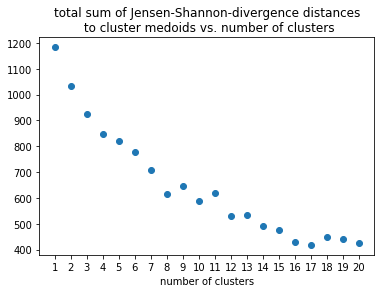

In [256]:
xinds = [i+1 for i,_ in enumerate(sum_dists)]
plt.scatter(xinds, sum_dists)
plt.title("total sum of Jensen-Shannon-divergence distances\n to cluster medoids vs. number of clusters")
plt.xlabel("number of clusters")
# plt.ylabel("sum of Jensen-Shannon divergence\n distances to medoid")
plt.xticks(xinds)

In [225]:
best_n = 8
M, C = kMedoids(D, best_n)

labels = [None for _ in range(len(lda_output))]
for label in C:
    for point_idx in C[label]:
        labels[point_idx] = label

In [226]:
clustered_titles = {}
get_title = lambda ind: all_articles[ind]['title']
for clust, inds in C.items():
    clustered_titles[clust] = list(map(get_title, inds))

In [243]:
distances_to_medoid_y = [(ind, jsd(lda_output[ind], lda_output[M[7]])) for ind in C[7]]

In [246]:
sorted_by_closest = sorted(distances_to_medoid_y, key=lambda tup: tup[1])

In [254]:
medoid_7_closest_10 = [all_articles[i]['title'] for i, _ in sorted_by_closest[1:11]]

In [255]:
medoid_7_closest_10

["Kansas' Udoka Azubuike Posterizes Villanova F with Monster NCAA Tournament Dunk",
 'Donte DiVincenzo Slams Putback Dunk Home over Texas Tech Defender',
 'Zach Norvell Jr. Buries Clutch 3-Pointer to Power Gonzaga Past UNC Greensboro',
 "Highlights: Oklahoma's Trae Young Scores 32 Points in 75-73 Loss to WVU - Bleacher Report",
 'Texas Tech Wins Thriller vs. Florida to Go to Sweet 16 in 2018 NCAA Tournament',
 "NCAA Tournament 2018: Friday's 1st-Round Scores, Updated Bracket and Schedule",
 "Full Highlights of Malik Newman's Monster 3-Point Shooting Performance vs. Duke",
 '2018 NCAA Tournament Round 2 Saturday Schedule, Game Times Announced',
 'Donte Ingram Buries Last-Second 3 to Give Loyola-Chicago Upset Win vs. Miami',
 'Malik Newman, Kansas Hang on to Beat Clemson, Advance to 2018 Elite Eight']

In [241]:
set(clustered_titles[7][:100]) # 4 seems to be about free agents.  7 about college basketball. 

{'2018 NCAA Tournament Round 2 Saturday Schedule, Game Times Announced',
 '36-Year-Old Accountant Scott Foster Makes NHL Debut as Emergency Goalie',
 "A'ja Wilson, Kelsey Mitchell, Diamond DeShields Comprise Stacked WNBA Draft",
 'After 832 Days Away from the Game, Johnny Football Is Back',
 'Artist Freehand Profit Creates Gas Masks from Rare and Popular Sneakers',
 'B/R x 4/20: A Letter from the Editor',
 'Basketball Meant Life or Death for Marcus Smart',
 'Become the Rory McIlroy of Tailgating with Beer Pong Golf',
 'Blue Jackets Forward Artemi Panarin Has the Cutest Trainer',
 'Butler Earns Lopsided Win over Arkansas in 2018 NCAA Tournament',
 "Cancer Survivor Daniel Jacobs Is Boxing's 'Miracle Man'",
 'Charles Matthews Throws Down Epic Dunk in Loyola-Chicago March Madness Matchup',
 "Conor McGregor Crashed the UFC's Media Day and All Hell Broke Loose",
 'Courtney Stockard Leads St. Bonaventure Past UCLA in 2018 NCAA First Four',
 "Deon Cain NFL Draft 2018: Scouting Report for India

Component's weights: 
 [[ 0.22  0.16  0.26  0.28  0.1   0.68  0.32  0.18  0.04  0.19  0.17  0.31
   0.11]
 [ 0.14  0.08  0.06  0.23 -0.04 -0.44  0.09  0.03  0.01  0.84 -0.05 -0.02
   0.05]]
Perc of Variance Explained: 
 [0.04 0.15]


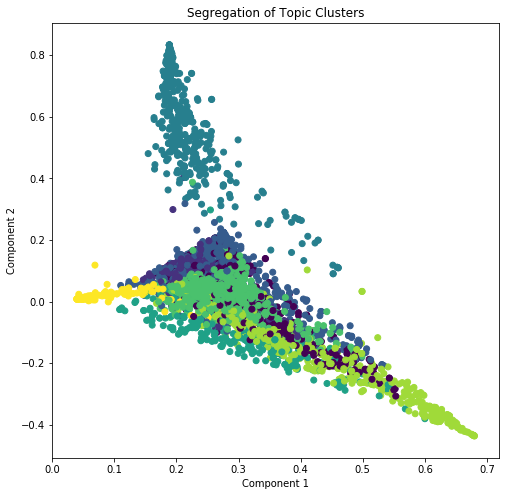

In [240]:
# Construct the k-means clusters
from sklearn.cluster import KMeans, AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters=10)
clusters = clusterer.fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]


# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=labels)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Text(0.5,1,'Segregation of Topic Clusters')

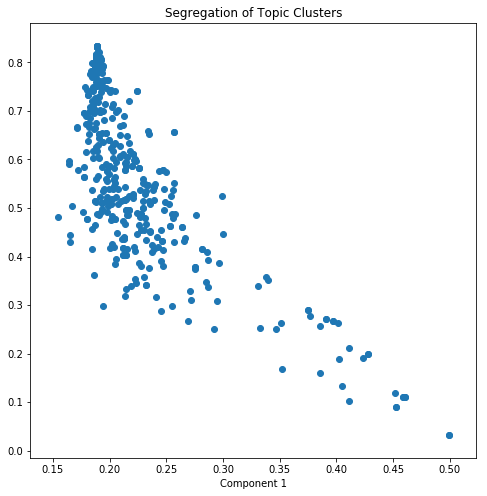

In [233]:
TOPIC = 7
modified_x = [x[i] for i,c in enumerate(clusters) if c==TOPIC]
modified_y = [y[i] for i,c in enumerate(clusters) if c==TOPIC]

plt.figure(figsize=(8,8))
plt.scatter(modified_x, modified_y)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
import numpy as np
from scipy.cluster.hierarchy import fclusterdata
from scipy.cluster.hierarchy import dendrogram, linkage

In [166]:
fclust1 = fclusterdata(lda_output, 10, criterion='maxclust', metric=jsd)

In [169]:
fclust1

array([5, 5, 5, ..., 5, 5, 5], dtype=int32)

In [123]:
# Construct the k-means clusters
from sklearn.cluster import KMeans, AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters=10)
clusters = clusterer.fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )


# # Weights for the 15 columns of lda_output, for each component
# print("Component's weights: \n", np.round(svd_model.components_, 2))
# # Percentage of total information in 'lda_output' explained by the two components
# print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Text(0.5,1,'total sum of squares to centroid vs. number of clusters')

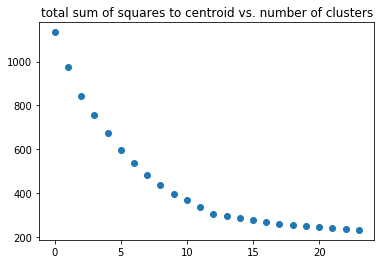

In [101]:
# inertias = []
# for n in range(1, 25):
#     clusterer = KMeans(n_clusters=int(n), random_state=100)
#     clusterer.fit(lda_output)
#     inertias.append(clusterer.inertia_)
    
# plt.scatter([i for i,_ in enumerate(inertias)], inertias)
# plt.title("total sum of squares to centroid vs. number of clusters")

In [103]:
def get_clusters(clusters, docs):
    cluster_dict = {}
    for c in set(clusters):
        cluster_dict[c] = [all_articles[i]['title'] for i,clust in enumerate(clusters) if clust==c]
    return cluster_dict
cluster_dict = get_clusters(clusters, docs)

In [149]:
# set(cluster_dict[7][:100]) # 4 and 7 work the best

In [76]:
# fifteen_clusters = [c for c in clusters]

### Plot the Two SVD Components

Text(0.5,1,'Segregation of Topic Clusters')

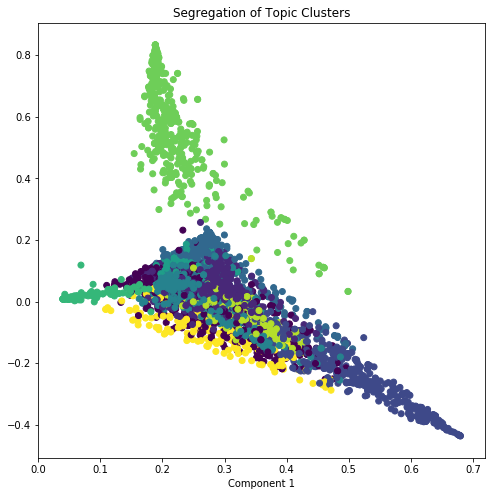

In [147]:
# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

Text(0.5,1,'Segregation of Topic Clusters')

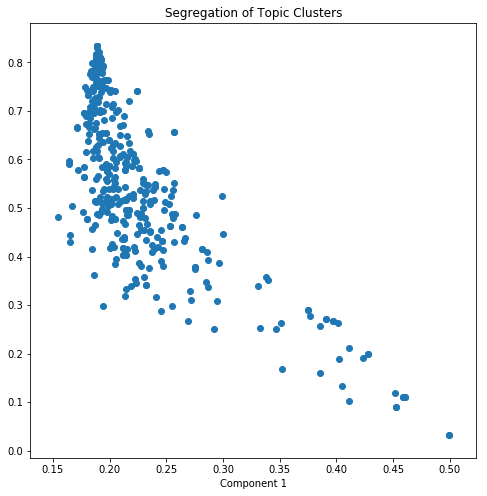

In [148]:
TOPIC = 7
modified_x = [x[i] for i,c in enumerate(clusters) if c==TOPIC]
modified_y = [y[i] for i,c in enumerate(clusters) if c==TOPIC]

plt.figure(figsize=(8,8))
plt.scatter(modified_x, modified_y)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )